# Download RM

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "reciprocate/dahoas-gptj-rm-static"
# rm = AutoModelForCausalLM.from_pretrained(model_id).to(device)
rm = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
# turn off gradients
for param in rm.parameters():
    param.requires_grad = False

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:50<00:00, 16.81s/it]
Some weights of the model checkpoint at reciprocate/dahoas-gptj-rm-static were not used when initializing GPTJForSequenceClassification: ['transformer.h.23.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.22.attn.masked_bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.21.attn.bias', 'transformer.h.7.attn.bias', 'transformer.h.8.attn.bias', 'transformer.h.16.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.2.attn.bias', 'tran

# Model Definitions

In [2]:
from torchtyping import TensorType
from torch import nn
class TiedSAE(nn.Module):
    def __init__(self, activation_size, n_dict_components):
        super().__init__()
        self.encoder = nn.Parameter(torch.empty((n_dict_components, activation_size)))
        nn.init.xavier_uniform_(self.encoder)
        self.encoder_bias = nn.Parameter(torch.zeros((n_dict_components,)))

    def get_learned_dict(self):
        norms = torch.norm(self.encoder, 2, dim=-1)
        return self.encoder / torch.clamp(norms, 1e-8)[:, None]

    def encode(self, batch):
        c = torch.einsum("nd,bd->bn", self.encoder, batch)
        c = c + self.encoder_bias
        c = torch.clamp(c, min=0.0)
        return c

    def decode(self, code: TensorType["_batch_size", "_n_dict_components"]) -> TensorType["_batch_size", "_activation_size"]:
        learned_dict = self.get_learned_dict()
        x_hat = torch.einsum("nd,bn->bd", learned_dict, code)
        return x_hat

    def forward(self, batch: TensorType["_batch_size", "_activation_size"]) -> TensorType["_batch_size", "_activation_size"]:
        c = self.encode(batch)
        x_hat = self.decode(c)
        return x_hat, c

    def n_dict_components(self):
        return self.get_learned_dict().shape[0]

# Download SAE

In [3]:
# from autoencoders import *
from huggingface_hub import hf_hub_download

layer = 15
rm_sae_repo_id = "Elriggs/dahoas-gptj-rm-sae"
rm_sae_filename = f"dahoas-gptj-rm-static_r4_transformer.h.{layer}.pt"
ae_download_location = hf_hub_download(repo_id=rm_sae_repo_id, filename=rm_sae_filename)
cache_name = f"transformer.h.{layer}"
autoencoder = torch.load(ae_download_location).to(device)
for param in autoencoder.parameters():
    param.requires_grad = False

# Download Dataset

In [2]:
from datasets import load_dataset
from torch.utils.data import DataLoader


# Function to tokenize and pad sequences to max length per batch
# def tokenize_and_pad(examples):
#     return tokenizer(examples['chosen'], padding="longest", truncation=True, return_attention_mask=False)
# # Load the dataset
# hh = load_dataset("Anthropic/hh-rlhf", split="train[:1000]").map(
#     tokenize_and_pad, batched=True
# )

from activation_dataset import chunk_and_tokenize
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_id = "reciprocate/dahoas-gptj-rm-static"
# rm = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Download the dataset
# This formats it, so every datapoint is max_length tokens long
# dataset_name="stas/openwebtext-10k"
dataset_name = "Anthropic/hh-rlhf"
max_seq_length=64
dataset = load_dataset(dataset_name, split="train")
dataset, _ = chunk_and_tokenize(dataset, tokenizer, max_length=max_seq_length, text_key="chosen")
max_tokens = dataset.num_rows*max_seq_length
print(f"Number of tokens: {max_tokens/1e6:.2f}M")

Found cached dataset json (/root/.cache/huggingface/datasets/Anthropic___json/Anthropic--hh-rlhf-a9fdd36e8b50b8fa/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


Number of tokens: 36.73M


# Feature Interp

In [27]:
from alpha_utils_interp import *
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(rm, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

100%|██████████| 78/78 [03:20<00:00,  2.57s/it]


In [28]:
# load in original_reward, ablated_reward, & reward_diff
dir = "rm_save_files"
original_reward = torch.load(f"{dir}/original_reward.pt")
ablated_reward = torch.load(f"{dir}/ablated_reward.pt")
reward_diff = torch.load(f"{dir}/reward_diff.pt")
# The above are features indexed by non-zero features
# We use the below to convert back to the original feature indices
feature_activations = torch.load(f"{dir}/feature_activations.pt")
nz_features = feature_activations.sum(0).nonzero()[:, 0]

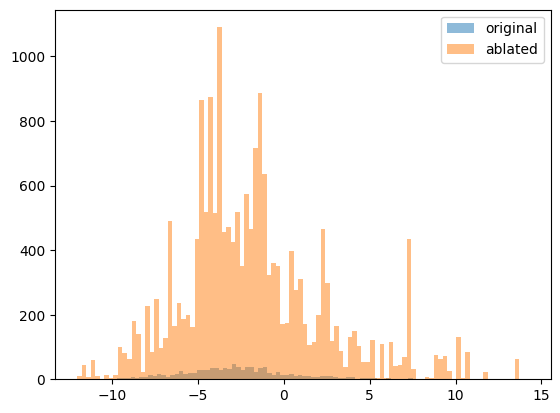

In [29]:
# Plot both original & ablated reward bins
import matplotlib.pyplot as plt
plt.hist(original_reward.flatten(), bins=100, alpha=0.5, label="original")
plt.hist(ablated_reward.flatten(), bins=100, alpha=0.5, label="ablated")
plt.legend()
plt.show()

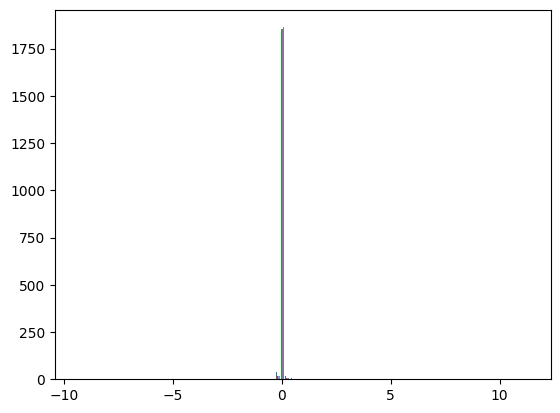

In [30]:
# plot reward_diff
plt.hist(reward_diff, bins=100)
plt.show()

In [31]:
reward_diff.max(0).values.topk(10, largest=True), reward_diff.min(0).values.topk(10, largest=False)
pos_features = nz_features[reward_diff.max(0).values.topk(10, largest=True).indices]
neg_features = nz_features[reward_diff.min(0).values.topk(10, largest=False).indices]

In [51]:
pos_reward_diff = reward_diff[:, reward_diff.max(0).values.topk(10, largest=True).indices]
neg_reward_diff = reward_diff[:, reward_diff.min(0).values.topk(10, largest=False).indices]
# Print out above w/ only 1 sig fig displayed
print(pos_reward_diff.sort(1).values.round())
print(pos_reward_diff.round())
print(neg_reward_diff.sort(1).values.round())

tensor([[ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2., 11.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  4.,  6.,  7.],
        [-0.,  0.,  0.,  0.,  0.,  0.,  2.,  6.,  9., 11.],
        [-0., -0.,  0.,  0.,  0.,  0.,  1.,  2.,  5.,  8.],
        [-7., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3.],
        [-0., -0.,  0.,  0.,  0.,  1.,  1.,  5.,  7., 11.],
        [-0., -0.,  0.,  0.,  0.,  1.,  1.,  1.,  6.,  8.],
        [-8., -0., -0.,  0.,  0.,  0.,  0.,  1.,  4.,  8.],
        [-0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  6.,  7.],
        [-4.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  3.]])
tensor([[11.,  2.,  2.,  1.,  1.,  0.,  0.,  1.,  0.,  1.],
        [ 4.,  7.,  6.,  1.,  0.,  1.,  0.,  1.,  0.,  0.],
        [11.,  9.,  2.,  6.,  0.,  0.,  0., -0.,  0.,  0.],
        [ 5.,  8., -0.,  1.,  2.,  0.,  0.,  0.,  0., -0.],
        [ 2.,  3., -7., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [11.,  7.,  5.,  1.,  1.,  0.,  0., -0.,  0., -0.],
        [ 6.,  8., -0.,  1.,  0.,  1., 

In [12]:
nz_features[pos_features]

tensor([16298,  9658, 10995,  2229])

In [52]:
# num_feature_datapoints = 5
model_type="causal"
features = pos_features
# features = neg_features
for feature in features:
    # Check if feature is dead (<10 activations)
    dead_threshold = 1
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    if(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        # Go to next feature
        continue
    print(f"Feature {feature} is alive")
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    save_token_display(full_token_list, full_activations, tokenizer, path =f"n/a", logit_diffs = None, save=False, model_type=model_type, show=True)

Feature 16298 is alive


Feature 9658 is alive


Feature 10995 is alive


Feature 2229 is alive


Feature 6662 is alive


Feature 13123 is alive


Feature 10500 is alive


Feature 7672 is alive


Feature 10870 is alive


Feature 6595 is alive


# Find datapoints indices that each feature activates on
For each prompt, save the summed (or maxxed?) feature activation for each feature. 
So if a curse word feature happens multiple times over a datapoint, we can measure how much it activated. Then we can match datapoints to the features that most activate on them.

In [75]:
# save feature_activations to rm_save_files, using torch
torch.save(feature_activations, "rm_save_files/feature_activations.pt")
torch.save(original_reward, "rm_save_files/original_reward.pt")

In [5]:
feature_activations = torch.load("rm_save_files/feature_activations.pt")
original_reward = torch.load("rm_save_files/original_reward.pt")

In [6]:
nz_features = feature_activations.sum(0).nonzero()[:, 0]

# Get reward & Counterfactual Reward (when ablating each feature)

In [10]:
from einops import rearrange
from baukit import Trace
from functools import partial
def less_than_rank_1_ablate(value, layer_name, autoencoder, feature):
    if(isinstance(value, tuple)):
        second_value = value[1]
        internal_activation = value[0]
    else:
        internal_activation = value
    # Only ablate the feature direction up to the negative bias
    # ie Only subtract when it activates above that negative bias.

    # Rearrange to fit autoencoder
    int_val = rearrange(internal_activation, 'b s h -> (b s) h')
    # Run through the autoencoder
    act = autoencoder.encode(int_val)
    dictionary_for_this_autoencoder = autoencoder.get_learned_dict()
    feature_direction = torch.outer(act[:, feature].squeeze(), dictionary_for_this_autoencoder[feature].squeeze())
    batch, seq_len, hidden_size = internal_activation.shape
    feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
    internal_activation -= feature_direction
    if(isinstance(value, tuple)):
        return_value = (internal_activation, second_value)
    else:
        return_value = internal_activation
    return return_value

from tqdm.auto import tqdm
batch_size = 8
num_nz_features = nz_features.shape[0]
k = 10
ablated_reward = torch.zeros((k, num_nz_features))
reward_diff = torch.zeros((k, num_nz_features))
with torch.no_grad(), hh.formatted_as("pt"):
    for feature_ind, feature in enumerate(tqdm(nz_features)):    
        intervention_function = partial(less_than_rank_1_ablate,  autoencoder=autoencoder, feature=feature)
        top_k_datapoints = feature_activations[:, feature].sort(descending=True).indices[:k]
        top_k_original_reward = original_reward[top_k_datapoints]
        # Get the top k datapoints from hh
        hh_dl = DataLoader(hh[top_k_datapoints]["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(hh_dl):
            batch = batch.to(device)
            with Trace(rm, output_cache_name, edit_output=intervention_function) as _:
                ablated_reward[i*batch_size:(i+1)*batch_size, feature_ind] = rm(batch).logits[:, 0].cpu()
        reward_diff[:, feature_ind] = top_k_original_reward - ablated_reward[:, feature_ind]

100%|██████████| 1889/1889 [6:16:58<00:00, 11.97s/it]  


In [8]:
top_k_datapoints

tensor([840, 623, 139, 557, 358, 813, 279, 736, 203, 469])

In [11]:
# Save both rewards
torch.save(ablated_reward, "rm_save_files/ablated_reward.pt")
torch.save(reward_diff, "rm_save_files/reward_diff.pt")

In [ ]:
diff_reward = torch.zeros((k, num_nz_features))
for f in range(num_nz_features):
    diff_reward[:, f] = ablated_reward[:, f] - original_reward[top_k_datapoints]

In [88]:
hh["input_ids"][top_k_datapoints.tolist()]

TypeError: list indices must be integers or slices, not list

In [93]:
hh[top_k_datapoints]["input_ids"]

[[198,
  198,
  20490,
  25,
  717,
  286,
  477,
  1309,
  502,
  910,
  1312,
  1101,
  645,
  1263,
  28318,
  618,
  340,
  2058,
  284,
  4819,
  13,
  1312,
  716,
  257,
  6823,
  10765,
  11,
  475,
  1312,
  716,
  407,
  257,
  2888,
  286,
  2035,
  1688,
  2151,
  393,
  597,
  2151,
  379,
  477,
  329,
  326,
  2300,
  13,
  220,
  1309,
  502,
  1234,
  340,
  503,
  612,
  25,
  703,
  460,
  262,
  17146,
  504,
  772,
  2074,
  48833,
  19997,
  287,
  48609,
  30,
  1422,
  470,
  262,
  582,
  14083,
  262,
  1499,
  1576,
  262,
  717,
  640,
  30,
  198,
  198,
  48902,
  25,
  1320,
  2331,
  588,
  257,
  2495,
  7702,
  1808,
  13,
  220,
  10347,
  345,
  4727,
  1521,
  345,
  821,
  3612,
  326,
  30,
  198,
  198,
  20490,
  25,
  1312,
  716,
  1290,
  422,
  852,
  257,
  1964,
  5887,
  13,
  475,
  355,
  281,
  4795,
  357,
  8727,
  39416,
  284,
  262,
  1364,
  11,
  1312,
  481,
  9159,
  326,
  8,
  1312,
  804,
  379,
  19997,
  290,
  1312,
  76

In [8]:
original_reward, ablated_reward

(tensor([-9.3261, -8.6817, -2.5550, -5.7167, -5.7340, -4.3358, -4.5054, -6.0947,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [19]:
def delete_feature(activations, layer_name, autoencoder, feature_to_ablate):
        # return activations
    # Check if tuple ie residual layer output as opposed to e.g. mlp output
    if isinstance(activations, tuple):
        temp_activations = activations[1]
        to_edit_activations = activations[0]
    else:
        to_edit_activations = activations

    b, s, n = to_edit_activations.shape
    mlp_flattened = rearrange(to_edit_activations, "b s n -> (b s) n")
    reconstruction_flattened, _ = autoencoder(mlp_flattened)
    reconstruction = rearrange(reconstruction_flattened, "(b s) n -> b s n", b=b, s=s)

    if isinstance(activations, tuple):
        reconstruction = tuple([reconstruction, temp_activations])
    return reconstruction

intervention_function = partial(less_than_rank_1_ablate,  autoencoder=autoencoder, feature = 0)

with Trace(rm, output_cache_name, edit_output=intervention_function) as _:
    rm(batch).logits[:, 0].cpu()

In [18]:
def less_than_rank_1_ablate(value, layer_name, autoencoder, feature):
    if(isinstance(value, tuple)):
        second_value = value[1]
        internal_activation = value[0]
    else:
        internal_activation = value
    # Only ablate the feature direction up to the negative bias
    # ie Only subtract when it activates above that negative bias.

    # Rearrange to fit autoencoder
    int_val = rearrange(internal_activation, 'b s h -> (b s) h')
    # Run through the autoencoder
    act = autoencoder.encode(int_val)
    dictionary_for_this_autoencoder = autoencoder.get_learned_dict()
    feature_direction = torch.outer(act[:, feature].squeeze(), dictionary_for_this_autoencoder[feature].squeeze())
    batch, seq_len, hidden_size = internal_activation.shape
    feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
    internal_activation -= feature_direction
    if(isinstance(value, tuple)):
        return_value = (internal_activation, second_value)
    else:
        return_value = internal_activation
    return return_value